Notebook: 

- Subtype classification with L1-Logit
- Feature importance with SHAP
- Most important gene embedded with BERT
- CLustering of embeddings


# Imports

In [117]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import shap 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns

from sklearn.preprocessing import StandardScaler

sc.settings.verbosity = 3 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

In [2]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,...,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197
1,NaN,100133144,0.1185,2.0342,0.5116,0.1034,-3.1094,-0.4877,-0.8870,0.0577,...,1.1529,0.5938,0.4161,-0.0182,-1.0264,-0.4623,0.0507,0.4778,-0.4763,0.2876
2,UBE2Q2P2,100134869,0.8030,0.6853,-0.3650,-1.5341,1.2744,1.1389,-0.7295,0.1724,...,0.7471,1.0861,0.0440,0.2981,-0.4821,0.2481,0.5676,0.4846,-0.6968,-0.9707


In [5]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose().dropna(axis=1)
df_clean.head()

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,-6.6197,0.1185,0.8030,1.9096,1.1627,-1.2910,-1.1661,-24.2671,-0.8905,-0.7464,...,-1.0345,-1.3155,-0.0235,0.7347,0.2169,-1.2143,0.4502,-0.8102,-1.2280,1.0099
TCGA-CS-4941-01,-6.6197,2.0342,0.6853,0.2687,-1.7875,-0.3693,0.5989,-24.2671,-0.2931,-0.8891,...,0.5681,-0.3297,0.9896,0.3312,-0.0860,-0.7410,0.9028,0.9552,0.1514,1.5061
TCGA-CS-4942-01,-6.6197,0.5116,-0.3650,0.7763,-0.0135,-1.8175,-2.1143,-24.2671,-1.0988,-0.8873,...,-0.2736,0.3326,1.1601,0.2281,-0.5701,-0.7399,0.6187,-0.1635,-0.5145,0.5814
TCGA-CS-4943-01,-6.6197,0.1034,-1.5341,1.9239,1.1169,-2.5350,-1.3505,-24.2671,-1.3783,-1.6739,...,2.9808,2.6781,0.6371,0.5073,0.1360,1.0996,0.9174,-0.2393,0.5748,0.5170
TCGA-CS-4944-01,-6.6197,-3.1094,1.2744,1.2506,1.0094,-2.5886,-2.1143,-24.2671,-0.4584,-1.6739,...,-1.6638,-1.1717,-0.8581,-0.9870,-0.9546,-0.5623,-0.1225,-0.6971,-2.9617,-0.5319


## Preprocess pipeline - Genomics + Clinical

In [16]:

## read patient data and preprocessing...

# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")


raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

df_sample_with_gene = df_clean.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})


X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

If there is NA values: False
There are 0 columns with the same value.
[]...


## Import gene decription

In [6]:
df_gene_reference = pd.read_table("./supplement_data/gene_table.tsv")
df_gene_reference.head()
#df_gene_description = df_clean.merge(df_gene_reference, how = "left", left_on = "Entrez_Gene_Id", right_on = "NCBI GeneID")

# here is the table with the description:
#df_important_gene_description.head(10)

,NCBI GeneID,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
0,7157,TP53,tumor protein p53,Homo sapiens,PROTEIN_CODING,7157.0,NCBI Ortholog
1,1956,EGFR,epidermal growth factor receptor,Homo sapiens,PROTEIN_CODING,1956.0,NCBI Ortholog
2,7124,TNF,tumor necrosis factor,Homo sapiens,PROTEIN_CODING,7124.0,NCBI Ortholog
3,348,APOE,apolipoprotein E,Homo sapiens,PROTEIN_CODING,348.0,NCBI Ortholog
4,7422,VEGFA,vascular endothelial growth factor A,Homo sapiens,PROTEIN_CODING,7422.0,NCBI Ortholog


# Run a simple classification model, get most important genes

In [29]:
clf = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
clf.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', penalty='l1', solver='saga')

In [30]:
# get the model coefficients
coefficients = clf.coef_
intercept = clf.intercept_

y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

print("Train score", clf.score(X_train, y_train), "\nTest Score", clf.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.90      0.95        21
           2       1.00      1.00      1.00        42

    accuracy                           0.98       127
   macro avg       0.99      0.97      0.98       127
weighted avg       0.98      0.98      0.98       127

Train score 1.0 
Test Score 0.984251968503937


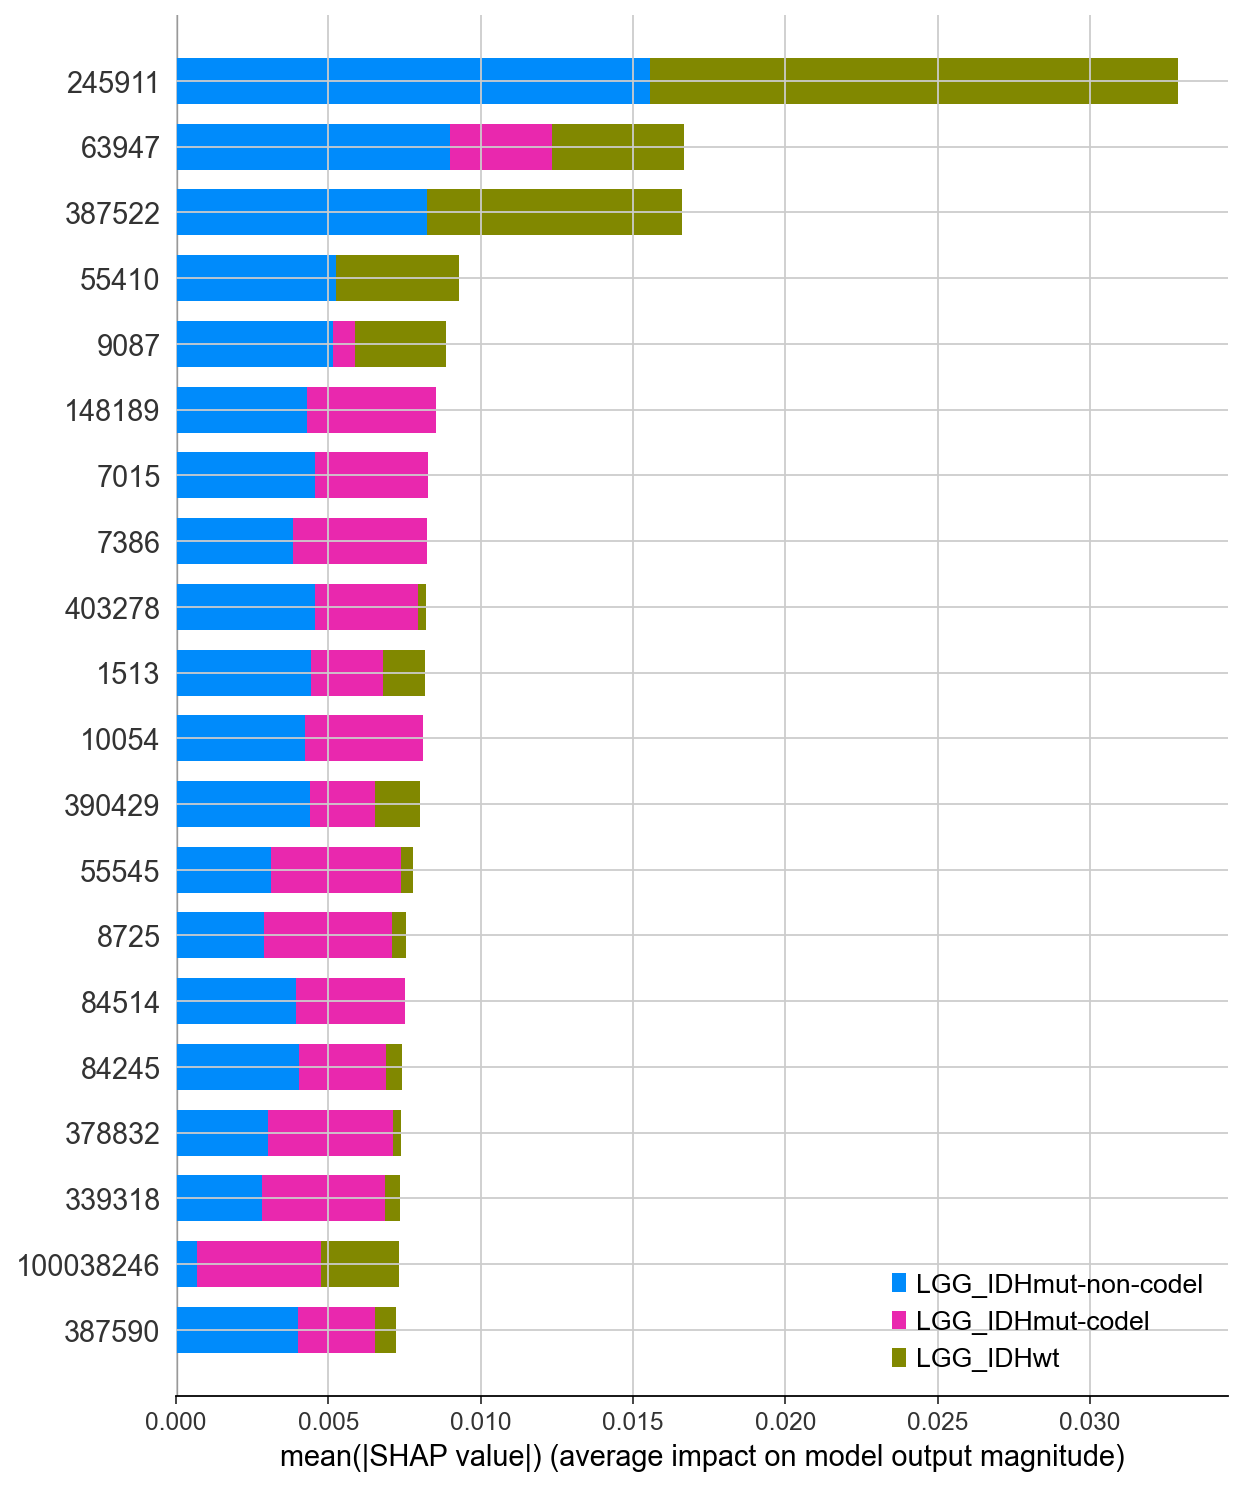

In [38]:
explainer = shap.Explainer(clf, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [46]:
top_n = 100
most_important_genes = pd.merge(feature_importance,df_gene_reference,
                                left_on='gene_id',
                                  right_on='NCBI GeneID').drop(['Taxonomic Name',
                                                                'Gene Group Identifier',
                                                                'Gene Group Method',
                                                                'NCBI GeneID'],
                                                                axis=1
                                                                )
n_most_important_genes = most_important_genes.nlargest(top_n, columns=['feature_importance_vals'])
n_most_important_genes.head(10)

,gene_id,feature_importance_vals,Symbol,Description,Gene Type
0,245911,1.392008,DEFB108B,defensin beta 108B,PROTEIN_CODING
1,63947,0.706501,DMRTC1,DMRT like family C1,PROTEIN_CODING
2,387522,0.703178,PEDS1-UBE2V1,PEDS1-UBE2V1 readthrough,PROTEIN_CODING
3,9087,0.375149,TMSB4Y,thymosin beta 4 Y-linked,PROTEIN_CODING
4,148189,0.360586,LINC00662,long intergenic non-protein coding RNA 662,ncRNA
5,7015,0.350235,TERT,telomerase reverse transcriptase,PROTEIN_CODING
6,7386,0.348640,UQCRFS1,"ubiquinol-cytochrome c reductase, Rieske iron-...",PROTEIN_CODING
7,403278,0.346722,OR5K4,olfactory receptor family 5 subfamily K member 4,PROTEIN_CODING
8,1513,0.345645,CTSK,cathepsin K,PROTEIN_CODING
9,10054,0.343657,UBA2,ubiquitin like modifier activating enzyme 2,PROTEIN_CODING


# pretrained BERT, encode descriptions, then cluster

In [50]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


In [130]:
descriptions = n_most_important_genes['Description']
embeddings = model.encode(descriptions)

In [131]:
embeddings.shape

(100, 384)

In [132]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
labels = pd.DataFrame(kmeans.labels_, columns=['cluster'])

In [133]:
clusters_df = pd.concat([n_most_important_genes, labels],axis=1)
clusters_df.groupby(by='cluster').count().iloc[:,0]


cluster
0    19
1     8
2    16
3     7
4    19
5    13
6     6
7    12
Name: gene_id, dtype: int64

# Looking at description

In [134]:

clusters_df[clusters_df['cluster']==0]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,cluster
2,387522,0.703178,PEDS1-UBE2V1,PEDS1-UBE2V1 readthrough,PROTEIN_CODING,0
16,339318,0.311747,ZNF181,zinc finger protein 181,PROTEIN_CODING,0
21,55900,0.291115,ZNF302,zinc finger protein 302,PROTEIN_CODING,0
26,54455,0.287166,FBXO42,F-box protein 42,PROTEIN_CODING,0
30,653567,0.280998,TMEM236,transmembrane protein 236,PROTEIN_CODING,0
43,84902,0.263867,CEP89,centrosomal protein 89,PROTEIN_CODING,0
51,54834,0.256160,GDAP2,ganglioside induced differentiation associated...,PROTEIN_CODING,0
63,11264,0.248829,PXMP4,peroxisomal membrane protein 4,PROTEIN_CODING,0
65,22847,0.247863,ZNF507,zinc finger protein 507,PROTEIN_CODING,0
67,83636,0.247400,C19orf12,chromosome 19 open reading frame 12,PROTEIN_CODING,0


In [135]:
clusters_df[clusters_df['cluster']==1]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,cluster
14,84245,0.314201,MRI1,methylthioribose-1-phosphate isomerase 1,PROTEIN_CODING,1
18,387590,0.305905,TPTEP1,TPTE pseudogene 1,PSEUDO,1
47,84842,0.259864,HPDL,4-hydroxyphenylpyruvate dioxygenase like,PROTEIN_CODING,1
49,515,0.258998,ATP5PB,ATP synthase peripheral stalk-membrane subunit b,PROTEIN_CODING,1
56,79947,0.251882,DHDDS,dehydrodolichyl diphosphate synthase subunit,PROTEIN_CODING,1
81,5511,0.237841,PPP1R8,protein phosphatase 1 regulatory subunit 8,PROTEIN_CODING,1
89,23028,0.233495,KDM1A,lysine demethylase 1A,PROTEIN_CODING,1
99,6390,0.230427,SDHB,succinate dehydrogenase complex iron sulfur su...,PROTEIN_CODING,1


In [138]:
clusters_df[clusters_df['cluster']==2]

,gene_id,feature_importance_vals,Symbol,Description,Gene Type,cluster
1,63947,0.706501,DMRTC1,DMRT like family C1,PROTEIN_CODING,2
11,55545,0.328870,MSX2P1,msh homeobox 2 pseudogene 1,PSEUDO,2
17,100038246,0.309847,TLX1NB,TLX1 neighbor,ncRNA,2
23,3209,0.289481,HOXA13,homeobox A13,PROTEIN_CODING,2
24,2297,0.288575,FOXD1,forkhead box D1,PROTEIN_CODING,2
33,3195,0.275076,TLX1,T cell leukemia homeobox 1,PROTEIN_CODING,2
36,79192,0.272819,IRX1,iroquois homeobox 1,PROTEIN_CODING,2
38,64211,0.270378,LHX5,LIM homeobox 5,PROTEIN_CODING,2
53,80341,0.253454,BPIFB2,BPI fold containing family B member 2,PROTEIN_CODING,2
55,3166,0.252460,HMX1,H6 family homeobox 1,PROTEIN_CODING,2


# PCA before clustering and plot

In [139]:
# Standardize the dataset X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Perform PCA on the standardized dataset X
pca = PCA(n_components=2)
pca.fit(X_scaled)

# Obtain the principal components and the explained variance ratios
principal_components = pca.transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
print('explained variance is',explained_variance.sum())

# Create a new DataFrame with the principal components and the "cluster" column
df_pca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

kmeans = KMeans(n_clusters=8).fit(df_pca)
labels = pd.DataFrame(kmeans.labels_, columns=['cluster'])


df_pca['cluster'] = labels



explained variance is 0.10505211


<Axes: xlabel='PC1', ylabel='PC2'>

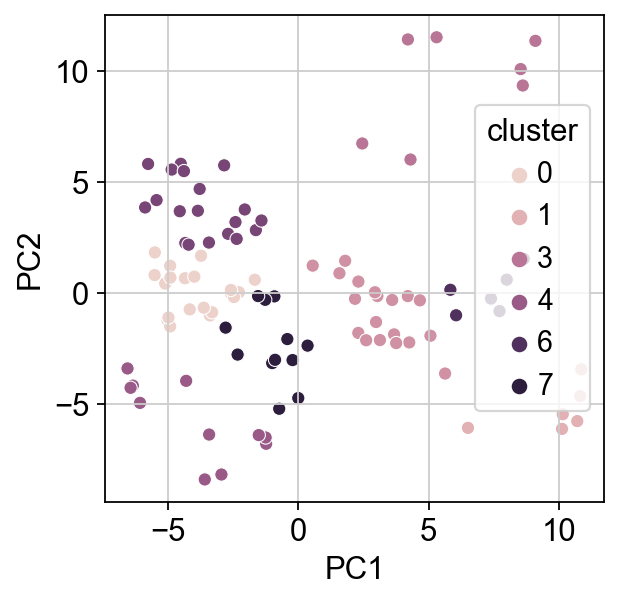

In [140]:
# Create a scatter plot of the principal components, colored by the "cluster" column
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster')
